In [1]:
# import ROOT
# ROOT.gEnv.SetValue("JupyROOT.EnableRCanvas", 0)


In [2]:
import uproot as ur
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
from tqdm import tqdm

In [3]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

OUTPUT_DIR = os.path.join(PROJECT_ROOT, "output")
FIG_DIR = os.path.join(PROJECT_ROOT, "figs")

os.makedirs(FIG_DIR, exist_ok=True)
X_INIT = 45_910
step_x = 2

In [4]:
import glob, os, pprint
pprint.pprint(glob.glob(os.path.join(OUTPUT_DIR, "run_*")))

['/home/arcadia/FCFD-Laser/output/run_20250925_150612_Power_80.0%',
 '/home/arcadia/FCFD-Laser/output/run_20250925_153917_Power_85.0%',
 '/home/arcadia/FCFD-Laser/output/run_20250925_154300_Power_90.0%']


In [5]:
def get_latest_run_dir(power, base_path=OUTPUT_DIR):
    pattern = os.path.join(base_path, f"run_*_Power_{power}%")
    run_dirs = sorted(glob.glob(pattern))
    if not run_dirs:
        raise FileNotFoundError(f"No run dir for Power={power}%")
    return run_dirs[-1]  # latest by name (timestamped)


In [6]:
def get_processed_data(power, idx, base_path=OUTPUT_DIR):
    run_dir = get_latest_run_dir(power, base_path)
    processed_path = os.path.join(run_dir, "processed")
    processed_files = glob.glob(os.path.join(processed_path, "*.root"))
    if not processed_files:
        raise FileNotFoundError(f"No .root files found in {processed_path}")
    sorted_files = sorted(
        processed_files,
        key=lambda path: int(re.search(r'run(\d+)\.root', path).group(1))
    )
    data_path = sorted_files[idx]
    with ur.open(data_path) as data_file:
        return data_file["pulse;1"]["LP2_50"].arrays(library="np")["LP2_50"] * 1e9

In [13]:
power = 80.0
idx = 0
data_file = get_processed_data(power, idx)


In [14]:
Laser_Lp2_50 = data_file[:, 0]
Strip1_Lp2_50 = data_file[:, 1]
Strip2_Lp2_50 = data_file[:, 3]
Strip3_Lp2_50 = data_file[:, 5]

dt1 = Strip1_Lp2_50 - Laser_Lp2_50
dt2 = Strip2_Lp2_50 - Laser_Lp2_50
dt3 = Strip3_Lp2_50 - Laser_Lp2_50

In [15]:
def clean(x, window=[45, 48]):
    mask = np.isfinite(x)
    mask = mask & (x > 1e-3)
    mask = mask & (x > window[0])
    mask = mask & (x < window[1])
    return x[mask]


--- Binned Fit Results ---
Strip 1: Amplitude=4.5, μ=46.0265, σ=0.0380
Strip 2: Amplitude=112.3, μ=45.6511, σ=0.0223
Strip 3: Amplitude=15.5, μ=45.3362, σ=0.0301


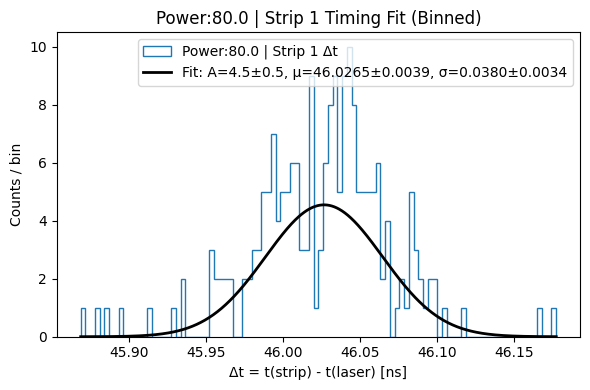

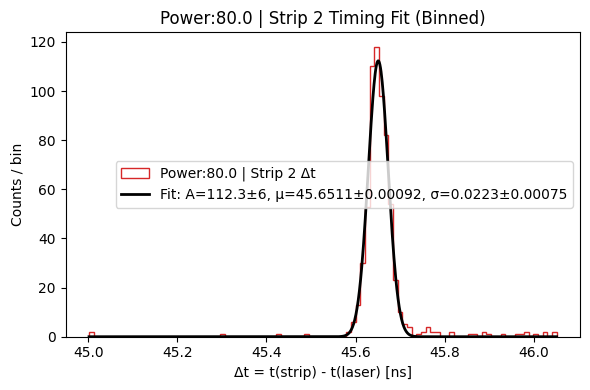

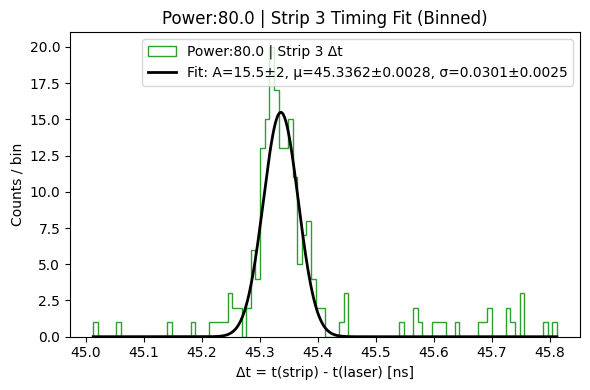

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares 
from scipy.stats import norm

def fit_binned_gaussian(data, bins=100):
    counts, edges = np.histogram(data, bins=bins)
    bin_centers = (edges[:-1] + edges[1:]) / 2
    
    y_err = np.sqrt(counts)
    y_err[y_err == 0] = 1

    def unscaled_gauss(x, A, mu, sigma):
        """A Gaussian function with an amplitude parameter 'A'."""
        return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

    cost = LeastSquares(bin_centers, counts, y_err, unscaled_gauss)

    m = Minuit(cost, A=np.max(counts), mu=np.mean(data), sigma=np.std(data))
    m.limits["sigma"] = (1e-6, None) 
    m.limits["A"] = (0, None)       
    m.migrad()
    m.hesse()
    return m

def plot_with_binned_fit(data, fit_result, strip_label, color='C0', bins=100):
    A = fit_result.values["A"]
    mu = fit_result.values["mu"]
    sigma = fit_result.values["sigma"]
    A_err = fit_result.errors["A"]
    mu_err = fit_result.errors["mu"]
    sigma_err = fit_result.errors["sigma"]

    fig, ax = plt.subplots(figsize=(6, 4))
    counts, edges, _ = ax.hist(data, bins=bins, histtype="step", label=f"{strip_label} Δt", color=color)

    xx = np.linspace(edges[0], edges[-1], 800)
    fitted_curve = A * np.exp(-0.5 * ((xx - mu) / sigma)**2)

    fit_label = (f"Fit: A={A:.1f}±{A_err:.1g}, μ={mu:.4f}±{mu_err:.2g}, σ={sigma:.4f}±{sigma_err:.2g}")
    ax.plot(xx, fitted_curve, color='k', lw=2, label=fit_label)
    
    ax.set_xlabel("Δt = t(strip) - t(laser) [ns]")
    ax.set_ylabel("Counts / bin")
    ax.legend()
    ax.set_title(f"{strip_label} Timing Fit (Binned)")
    plt.tight_layout()
    plt.show()


dt1 = clean(dt1, window=[45.8, 46.2])
dt2 = clean(dt2)
dt3 = clean(dt3)

fit1 = fit_binned_gaussian(dt1)
fit2 = fit_binned_gaussian(dt2)
fit3 = fit_binned_gaussian(dt3)


# mu1, sd1 = norm.fit(dt1)
# mu2, sd2 = norm.fit(dt2)
# mu3, sd3 = norm.fit(dt3)

# print(f"Strip1: μ={mu1:.3g}, σ={sd1:.3g}")
# print(f"Strip1: μ={mu2:.3g}, σ={sd2:.3g}")
# print(f"Strip1: μ={mu3:.3g}, σ={sd3:.3g}")


print("--- Binned Fit Results ---")
print(f"Strip 1: Amplitude={fit1.values['A']:.1f}, μ={fit1.values['mu']:.4f}, σ={fit1.values['sigma']:.4f}")
print(f"Strip 2: Amplitude={fit2.values['A']:.1f}, μ={fit2.values['mu']:.4f}, σ={fit2.values['sigma']:.4f}")
print(f"Strip 3: Amplitude={fit3.values['A']:.1f}, μ={fit3.values['mu']:.4f}, σ={fit3.values['sigma']:.4f}")

plot_with_binned_fit(dt1, fit1, f"Power:{power} | Strip 1", color="C0")
plot_with_binned_fit(dt2, fit2, f"Power:{power} | Strip 2", color="C3")
plot_with_binned_fit(dt3, fit3, f"Power:{power} | Strip 3", color="C2")

--- Binned Fit Results ---
Strip 1: Amplitude=7.4, μ=46.4994, σ=0.0567
Strip 2: Amplitude=104.8, μ=45.5607, σ=0.0276
Strip 3: Amplitude=18.1, μ=45.4095, σ=0.0291


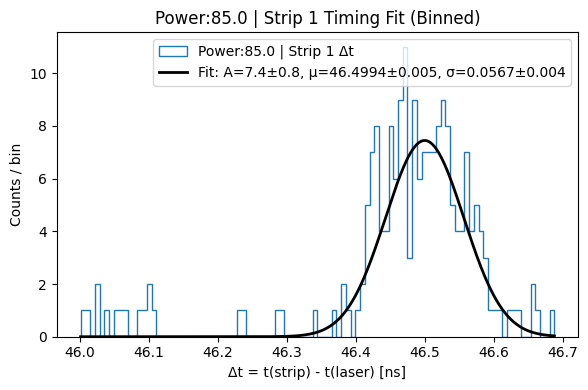

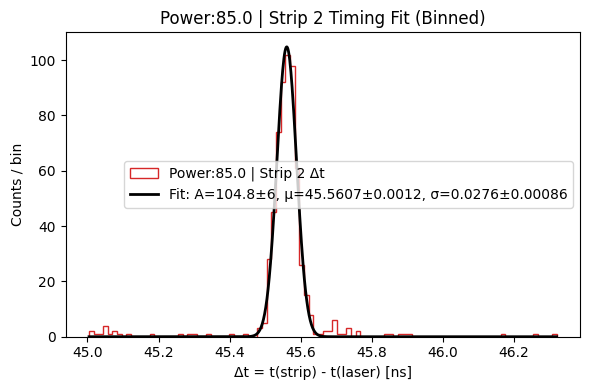

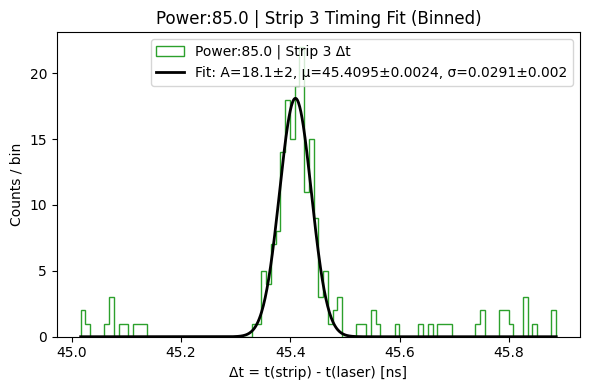

In [11]:
power = 85.0
idx = 0
data_file = get_processed_data(power, idx)
Laser_Lp2_50 = data_file[:, 0]
Strip1_Lp2_50 = data_file[:, 1]
Strip2_Lp2_50 = data_file[:, 3]
Strip3_Lp2_50 = data_file[:, 5]

dt1 = Strip1_Lp2_50 - Laser_Lp2_50
dt2 = Strip2_Lp2_50 - Laser_Lp2_50
dt3 = Strip3_Lp2_50 - Laser_Lp2_50


dt1 = clean(dt1, window=[46.0, 46.7])
dt2 = clean(dt2)
dt3 = clean(dt3)

fit1 = fit_binned_gaussian(dt1)
fit2 = fit_binned_gaussian(dt2)
fit3 = fit_binned_gaussian(dt3)

print("--- Binned Fit Results ---")
print(f"Strip 1: Amplitude={fit1.values['A']:.1f}, μ={fit1.values['mu']:.4f}, σ={fit1.values['sigma']:.4f}")
print(f"Strip 2: Amplitude={fit2.values['A']:.1f}, μ={fit2.values['mu']:.4f}, σ={fit2.values['sigma']:.4f}")
print(f"Strip 3: Amplitude={fit3.values['A']:.1f}, μ={fit3.values['mu']:.4f}, σ={fit3.values['sigma']:.4f}")

plot_with_binned_fit(dt1, fit1, f"Power:{power} | Strip 1", color="C0")
plot_with_binned_fit(dt2, fit2, f"Power:{power} | Strip 2", color="C3")
plot_with_binned_fit(dt3, fit3, f"Power:{power} | Strip 3", color="C2")

--- Binned Fit Results ---
Strip 1: Amplitude=nan, μ=nan, σ=nan
Strip 2: Amplitude=8.7, μ=49.4908, σ=1.6089
Strip 3: Amplitude=11.1, μ=45.6890, σ=0.6033


/home/arcadia/.local/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/arcadia/.local/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/arcadia/.local/lib/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/arcadia/.local/lib/python3.9/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/arcadia/.local/lib/python3.9/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


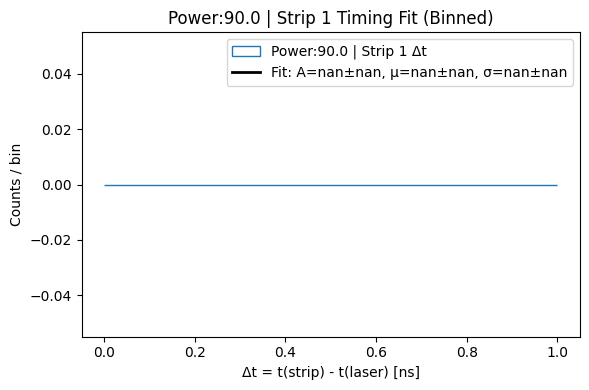

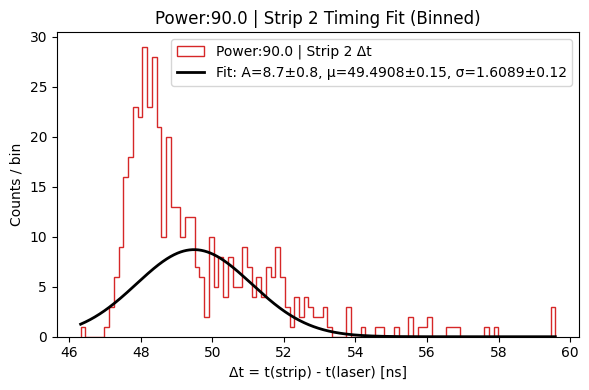

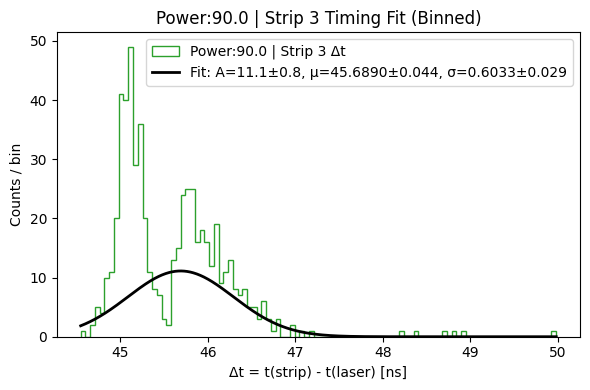

In [12]:
power = 90.0
idx = 0
data_file = get_processed_data(power, idx)
Laser_Lp2_50 = data_file[:, 0]
Strip1_Lp2_50 = data_file[:, 1]
Strip2_Lp2_50 = data_file[:, 3]
Strip3_Lp2_50 = data_file[:, 5]

dt1 = Strip1_Lp2_50 - Laser_Lp2_50
dt2 = Strip2_Lp2_50 - Laser_Lp2_50
dt3 = Strip3_Lp2_50 - Laser_Lp2_50


dt1 = clean(dt1, window=[1, 100])
dt2 = clean(dt2, window=[1, 60])
dt3 = clean(dt3, window=[1, 50])

fit1 = fit_binned_gaussian(dt1)
fit2 = fit_binned_gaussian(dt2)
fit3 = fit_binned_gaussian(dt3)

print("--- Binned Fit Results ---")
print(f"Strip 1: Amplitude={fit1.values['A']:.1f}, μ={fit1.values['mu']:.4f}, σ={fit1.values['sigma']:.4f}")
print(f"Strip 2: Amplitude={fit2.values['A']:.1f}, μ={fit2.values['mu']:.4f}, σ={fit2.values['sigma']:.4f}")
print(f"Strip 3: Amplitude={fit3.values['A']:.1f}, μ={fit3.values['mu']:.4f}, σ={fit3.values['sigma']:.4f}")

plot_with_binned_fit(dt1, fit1, f"Power:{power} | Strip 1", color="C0")
plot_with_binned_fit(dt2, fit2, f"Power:{power} | Strip 2", color="C3")
plot_with_binned_fit(dt3, fit3, f"Power:{power} | Strip 3", color="C2")